# Decision Trees

**Decision Trees** are versatile ML algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets and they are the fundamental components of Random Forests.

Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called **white box models**. In contrast, Random Forests or neural networks are generally considered **black box models**. They make great predictions, and we can  check the calculations performed to make predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if needed.

1. [Classification](#Classification)
2. [The CART Training Algorithm](#The-CART-Training-Algorithm)
3. [Regression](#Regression)
4. [Instability](#Instability)
5. [Exercise](#Exercise)

## Classification
To understand Decision Trees, let’s start with an example based on the iris dataset, using the SciKitLearn **DecisionTreeClassifier** class and the **plot_tree()** method:

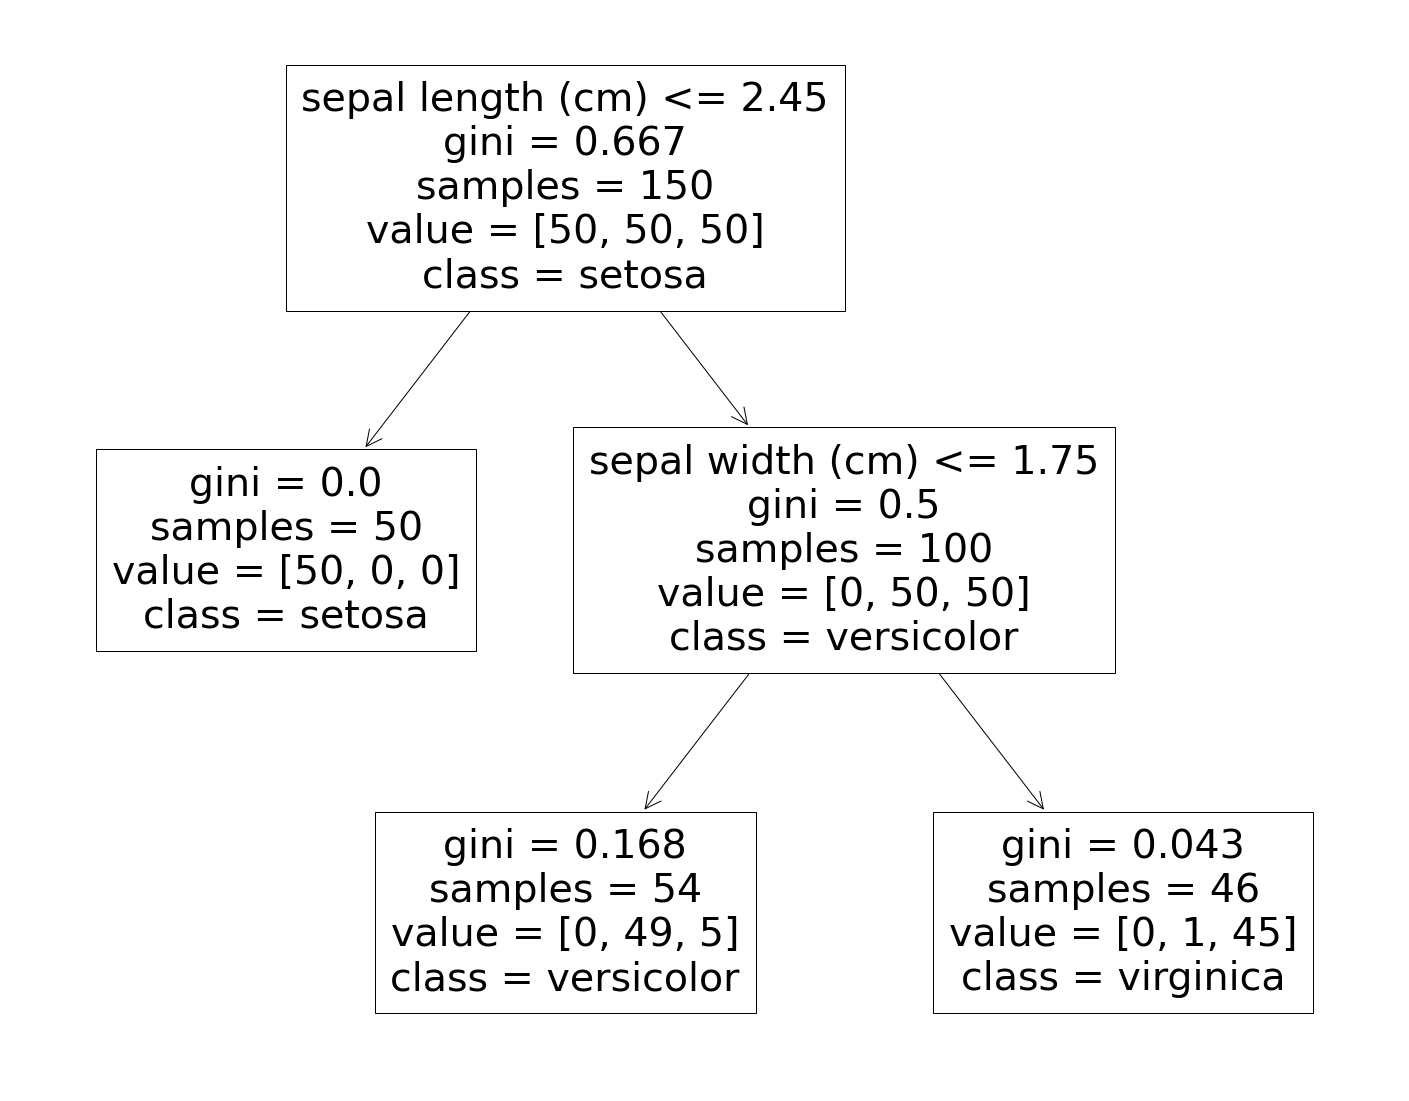

In [19]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

fig = plt.figure(figsize=(25,20))
plot = tree.plot_tree(tree_clf, 
                      feature_names=iris.feature_names,  
                      class_names=iris.target_names)

How the tree represented in this figure makes predictions? Suppose you find an iris
and you want to classify it. You start at the **root node**, it asks whether the petal length is smaller than 2.45 cm. If it is, then you move down to the left **child node**. It is a **leaf node** (no other child nodes), so it does not ask questions, it gives the predicted class (setosa). Now suppose you find another flower with petal length greater than 2.45 cm. You have to move down to the right child node, which is not a leaf node, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely a versicolor. If not, it is likely a virginica.

One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.

The other information of each nodes are:

- **samples** attribute counts how many training instances it applies to
- **value** attribute tells how many training instances of each class this node applies
- **gini** attribute measures its **impurity**

A node is **pure** (gini=0) if all training instances it applies to belong to the same class:

$\begin{align}
G_i=1-\Sigma_{k=1}^{n}p^{2}_{i,k}
\end{align}$

where $p_{i,k}$ is the ratio of class k instances among the training instances in the i node.

We can draw the decision boundaries:

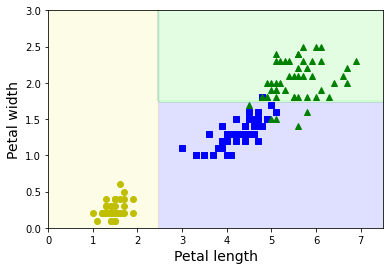

In [20]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

plot_decision_boundary(tree_clf, X, y, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)

plt.show()

A Decision Tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, check a flower whose petals are 5 cm long and 1.5 cm wide:

In [21]:
print(tree_clf.predict_proba([[5, 1.5]]))
print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


## The CART Training Algorithm
Scikit-Learn uses the **Classification and Regression Tree (CART)** algorithm to train Decision Trees. The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$. It searches for the pair $(k,t_k)$ that produces the **purest subsets** (weighted by their size). 
This is the cost fuction that CART tries to minimize:

$\begin{align}
J(k,t_k)=\frac{m_\text{left}}{m}G_\text{left}+\frac{m_\text{right}}{m}G_\text{right}
\end{align}$

where

- $G_\text{left/right}$ measures the impurity of the left/right subset
- $m_\text{left/right}$ is the number of instances in the left/right subset

Once the algorithm has splitted the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the **max_depth** hyperparameter), or if it cannot find a split that will reduce impurity.

The CART algorithm is a **greedy algorithm**: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s **reasonably good** but not guaranteed to be optimal.

Unfortunately, finding the optimal tree is known to be an [**NP-Complete problem**](https://www.youtube.com/watch?v=YX40hbAHx3s). So, it requires $O(exp(m))$ time, making the problem intractable even for small training sets. 

Making predictions requires traversing the Decision Tree from the root to a leaf, which requires going through roughly $O(log_2(m))$ nodes. So predictions are very fast, even when dealing with large training sets.

By default, the Gini measure is used, but we can select the **Entropy measure** by setting the **criterion hyperparameter** accordingly. The concept of [Entropy](https://machinelearningmastery.com/what-is-information-entropy/) (from Shannon’s information theory) measures the average information content of a message. If a node contains instances of only one class its Entropy is zero. The formal definition of Entropy of the $i^\text{th}$ node is:

$\begin{align}
H_i=-\Sigma_{k=1}^{n}p_{i,k}\log_2(p_{i,k})
\end{align}$

Gini and Entropy lead to similar trees. Gini impurity is slightly faster to compute, while entropy tends to produce slightly more balanced trees.

## Regularization
Decision Trees make very few assumptions about the training data (as opposed to linear
models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. Such a model is often called a **non-parametric model**, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a **parametric model**, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting, you need to restrict the Decision Tree’s freedom during training. 
The **DecisionTreeClassifier** class has a few parameters that restrict the shape of the tree: 
- **max_depth** the maximum depth of the tree
- **min_samples_split** the minimum number of samples a node must have before it can be split 
- **min_samples_leaf** the minimum number of samples a leaf node must have
- **min_weight_fraction_leaf** same as min_samples_leaf but expressed as a fraction of the total number of weighted instances)
- **max_leaf_nodes** the maximum number of leaf nodes
- **max_features** the maximum number of features that are evaluated for splitting at each node 

Other algorithms work by first training the tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the [$\chi^2$ test](https://en.wikipedia.org/wiki/Chi-squared_test), are used to estimate the probability that the improvement is purely the result of chance.

We can train two trees (one with the default hyperparameters and one withm min_samples_leaf=4) over the **moons dataset**: a toy dataset for binary classification in which the data points are shaped as two interleaving half circles.

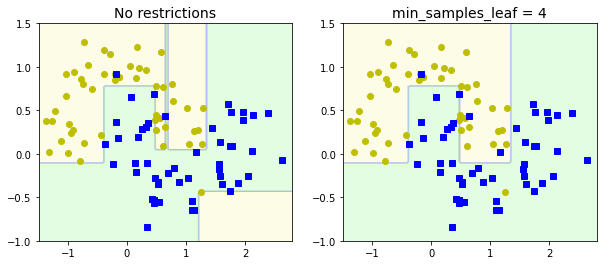

In [4]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

tree_clf_1 = DecisionTreeClassifier(random_state=42)
tree_clf_1.fit(Xm, ym)

tree_clf_2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
tree_clf_2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plot_decision_boundary(tree_clf_1, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(tree_clf_2, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("min_samples_leaf = {}".format(tree_clf_2.min_samples_leaf), fontsize=14)

plt.show()

It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

## Regression
Decision Trees are also capable of performing regression tasks. 
Let’s build a tree using Scikit-Learn’s **DecisionTreeRegressor** class, training it on a noisy quadratic dataset, with max_depth=2

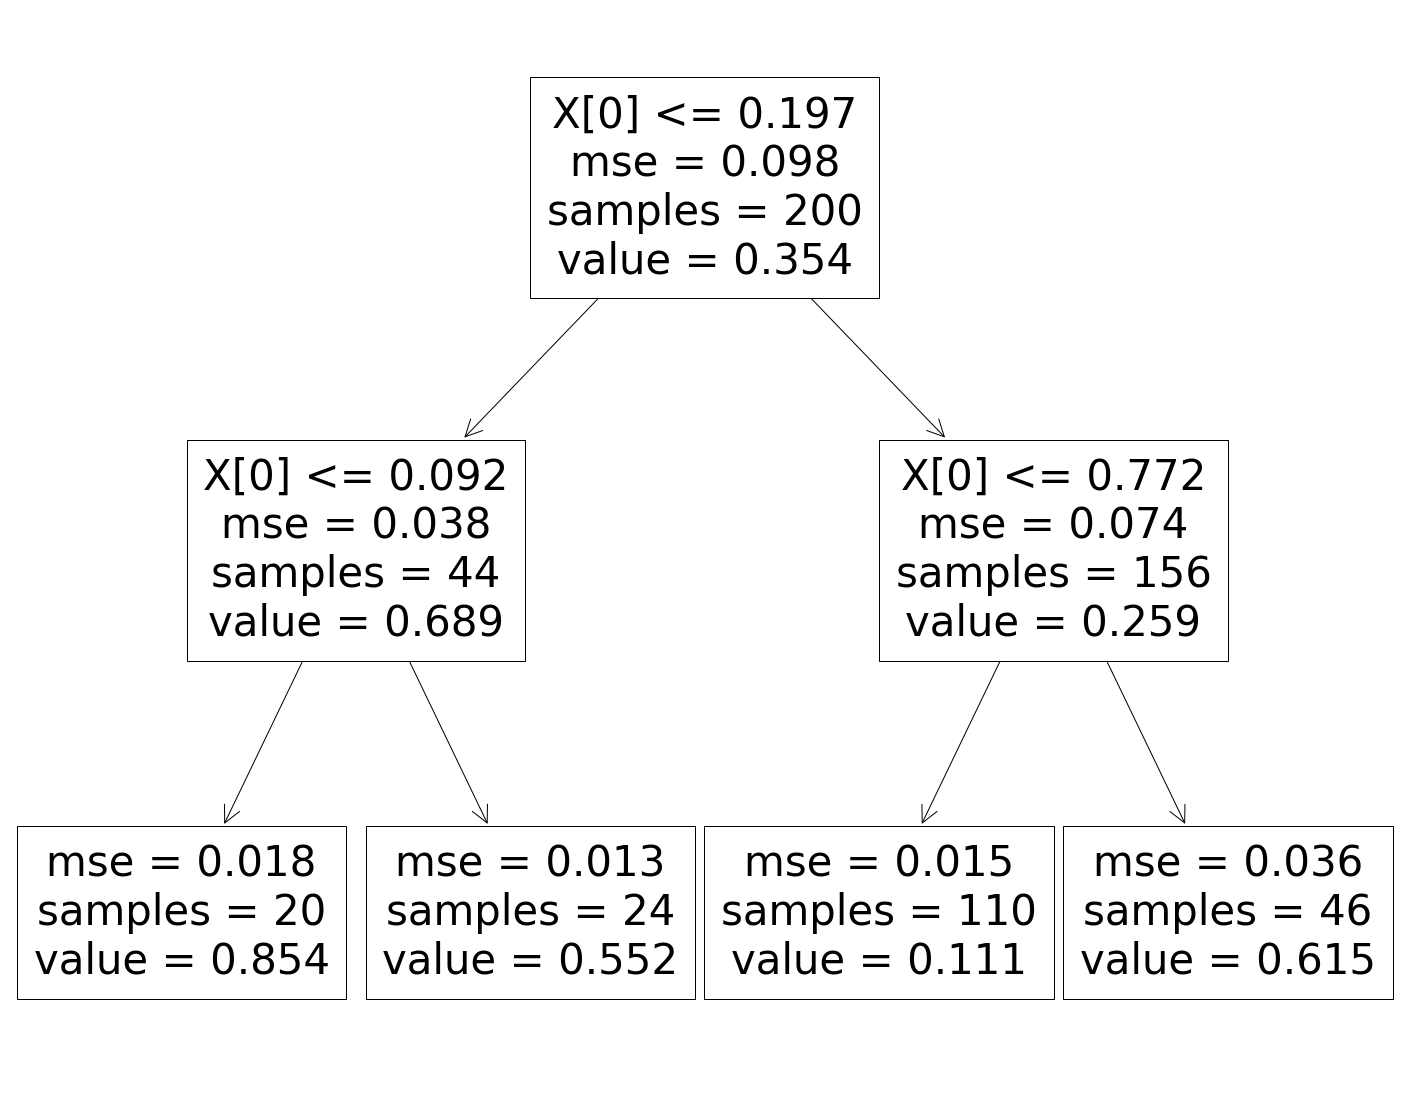

In [5]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2 + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

fig = plt.figure(figsize=(25,20))
plot = tree.plot_tree(tree_reg)

This tree instead of predicting a class in each node, it predicts a value. 
For example, suppose we want to make a prediction for a new instance with $x=0.6$, we traverse the tree starting at the root, and we each the leaf node that predicts value=0.111. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances.

We can show the prediction also enlarging che max_depth value:

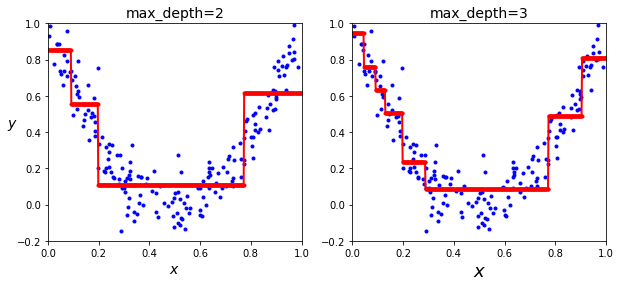

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg1.fit(X, y)

tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plot_regression_predictions(tree_reg1, X, y)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plot_regression_predictions(tree_reg2, X, y)
plt.title("max_depth=3", fontsize=14)

plt.show()

Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE:

$\begin{align}
J(k,t_k)=\frac{m_\text{left}}{m}\text{MSE}_\text{left}+\frac{m_\text{right}}{m}\text{MSE}_\text{right}
\end{align}$

where

- $\text{MSE}_\text{node}=\Sigma_{i\in\text{node}}(\hat{y}_\text{node}-y^{(i)})^2$
- $\hat{y}_\text{node}=\frac{1}{m_\text{node}}\Sigma_{i\in\text{node}}y^{(i)}$


Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get predictions obviously overfitting thec training set very badly. Just setting min_samples_leaf=10 results in a much more reasonable model.

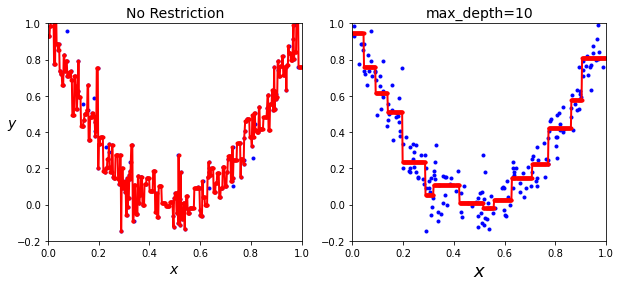

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg1.fit(X, y)

tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plot_regression_predictions(tree_reg1, X, y)
plt.title("No Restriction", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plot_regression_predictions(tree_reg2, X, y)
plt.title("max_depth=10", fontsize=14)

plt.show()

## Instability
Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However, they do have a few limitations. 

Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, considerging a simple linearly separable dataset, a Decision Tree can split it easily, but after the dataset is rotated, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model will not generalize well

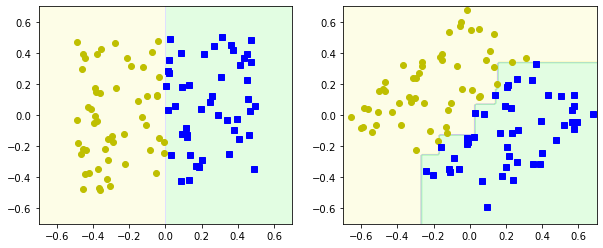

In [8]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)

tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "yo")
plt.plot(Xs[:, 0][ys==2], Xs[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])

plt.sca(axes[1])
plt.plot(Xsr[:, 0][ys==0], Xsr[:, 1][ys==0], "yo")
plt.plot(Xsr[:, 0][ys==2], Xsr[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])

plt.show()

More generally, the main issue is that they are very **sensitive to small variations in the training data**. Random Forests can limit this instability by averaging predictions over many trees.

For example, if you just remove the widest Iris versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get a relly different model.

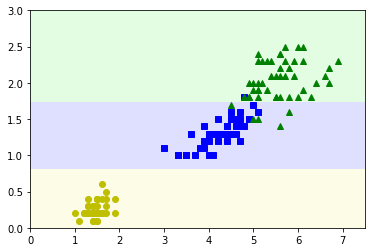

In [22]:
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.show()

## Exercise

**1 - Train and fine-tune a Decision Tree for the moons dataset by following these steps: (a) use make_moons(n_samples=10000, noise=0.4) to generate a moons
dataset; (b) use train_test_split() to split the dataset into a training set and a test
set; (c) use grid search with cross-validation (with the help of the GridSearchCV
class) to find good hyperparameter values for a DecisionTreeClassifier; (d) train it on the full training set using these hyperparameters, and measure your model’s performance on the test set.**

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              params, verbose=0, cv=3)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)


0.8695

**2 - Grow a forest by following these steps: (a) continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly; (b) train one Decision Tree on each subset, using the best hyperparameter
values found in the previous exercise, evaluate these 1,000 Decision Trees
on the test set (since they were trained on smaller sets, these Decision Trees
will likely perform worse than the first Decision Tree, achieving only about
80% accuracy); (c) Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction; (d) evaluate these predictions on the test set: you should obtain a slightly higher
accuracy than your first model**

In [28]:
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, 
                  test_size=len(X_train) - n_instances, 
                  random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))
    
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
print(np.mean(accuracy_scores))  

Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8054499999999999


0.872